<a id="top"></a>
# Самостоятельный проект. Анализ бизнес показателей


Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

Вам предстоит изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

## Подготовка и получение данных

### Имборт библиотек

In [1]:
    import pandas as pd
    import numpy as np
    from datetime import datetime, timedelta
    from matplotlib import pyplot as plt
    import seaborn as sns
    import warnings
    warnings.filterwarnings("ignore")


### Функции для использования в проекте

#### Функция для расчета retention rate(raw data и таблица удержания)


In [2]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
 
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
 
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
 
    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
 
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
 
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
 
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
 
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time
 

#### Функция для получения профиля пользователей

In [3]:
def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )
    new_users['dt'] = pd.to_datetime(new_users['dt'])

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles['dt'] = pd.to_datetime(profiles['dt'])
    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(
        0
    )
    
    return profiles  # возвращаем профили с CAC

#### Функция для расчета LTV и ROI

In [4]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функция для получения конверсии

In [5]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для построения графиков удержания

In [6]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Функция для построения графиков конверсии

In [7]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция для построения графиков LTV/ROI

In [8]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(30, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [9]:
# функция для сглаживания датафрейма
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Работа с данными

#### Чтение файлов

In [10]:
sessions = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
ad_costs = pd.read_csv('/datasets/costs_info_short.csv')

#### Работа с таблицей sessions

Для начала проверим первую таблицу с посещениями пользователей. Посмотрим первые 5 строк.

In [11]:
sessions.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Необходимо переименовать столбцы и привести их к "змеинному" регистру. По названию столбцов нареканий нет.

In [12]:
#sessions.set_axis(
    #['user_id', 'region', 'device', 'channel', 'session_start', 'session_end'], 
   # axis = 'columns', 
   # inplace = True
#)
sessions.columns = sessions.columns.str.lower().str.replace(' ', '_')
sessions.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Названия столбцов скорректировали, дальше проверим типы данных и пропуски.

In [13]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Пропусков в таблице нет. Необходимо преобразовать столбцы **session_start** и **session_end**.

In [14]:
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
sessions['session_end'] = pd.to_datetime(sessions['session_end'])
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Проверим столбцы region, device, channel на наличие неявных дубликатов. 

In [15]:
sessions['region'].unique()


array(['United States', 'UK', 'France', 'Germany'], dtype=object)

По региону проблем нет. Смотрим девайсы.

In [16]:
sessions['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

По девайсам все тоже хорошо, проверяем каналы, откуда пришли пользователи.

In [17]:
sessions['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Названия каналов "креативные", но и с ними проблем нет. Переходим к следующему датафрейму.

#### Работа с таблицей orders

Посмотрим на первые 5 строк датафрейма.

In [18]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Переименуем названия столбцов и приведем их  в змеиному регистру.

In [19]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Преобразуем данные в столбце event_dt.

In [20]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Пропусков в таблице нет, все данные в нужном нам формате. Переходим к следующей таблице.

#### Работа с таблицей ad_costs

Посмотрим на первые 5 строк.

In [21]:
ad_costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Переименуем стоблцы - приведем их к нижнему регистру и немного изменим название.

In [22]:
ad_costs.columns = ad_costs.columns.str.lower()
ad_costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [23]:
ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


Пропусков нет, проверим таблицу на неявные дубликаты.

In [24]:
ad_costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Тип данных преобразовали, дубликатов нет.

### Вывод по первому этапу

Мы преобразовали тип данных в каждой таблице к нужным нам, прописали все необходимые нам функции и импортировали все библиотеки. Можно приступать к исследовательскому анализу данных.

## Исследовательский анализ данных.

### Создание пользовательских профилей. Определяем минимальную и максимальную дату привлечения.

Запустим функцию **get_profiles** для создания пользовательского профиля.

In [25]:
profiles = get_profiles(sessions, orders,  ad_costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Мы получили профили пользователей. Далее опеределяем минимальную и максимальную дату привлечения пользователей.

In [26]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [27]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

Первый пользователь в наших данных появился 1 мая 2019 года, последний пользователь 27 октября 2019 года. 

### Анализ привлечения пользователей по странам и определение самой платежеспособной страны.

Для начала посмотрим из каких стран приходят пользователи и в каком кол-ве.

In [28]:
print(profiles.groupby('region').agg({'user_id': 'nunique'})) 

               user_id
region                
France           17450
Germany          14981
UK               17575
United States   100002


Судя по таблице большинство пользователей из США. Всего в приложения за этот период заходили пользователи из 4 стран. Теперь посмотрим, на какую страну приходится больше всего платежных пользователей. Создадим сводную таблицу.

In [29]:
payers_by_country = profiles.pivot_table(values = 'user_id',
                                         index = 'region',
                                         columns = 'payer',
                                         aggfunc = {'user_id':'nunique'}
                                        )

payers_by_country['%'] = (payers_by_country.iloc[:, -1]/(payers_by_country.iloc[:, -1]+payers_by_country.iloc[:, -2])*100).round(1)
payers_by_country

payer,False,True,%
region,,,
France,16787,663,3.8
Germany,14365,616,4.1
UK,16875,700,4.0
United States,93100,6902,6.9


США снова попадает на первое место по кол-ву платежеспособных пользователей. В Франции, Германии и Объединённых королевствах платят примерно 4% от общего кол-ва пользователей, в то время как в США эта отметка приближается к 7%.
Далее посмотрим данные по пользовательским предпочтениям в плане устройст и какие устройства выбирают платежеспособные пользователи.

### Анализ пользовательских предпочтений по устройствам.

Для начала посмотрим, какая доля у каждого устройства в приложении, построив сводную таблицу.

In [30]:
print(profiles.groupby('device').agg({'user_id': 'nunique'})) 

         user_id
device          
Android    35032
Mac        30042
PC         30455
iPhone     54479


Больше всего пользуются приложением пользователи "Яблока", на втором месте пользователи ПК. Проверим, какие устройства предпочитают платящие пользователи.

In [31]:
payers_by_device = profiles.pivot_table(values = 'user_id',
                                        index = 'device',
                                        columns = 'payer',
                                        aggfunc = 'nunique',
                                        )
payers_by_device['%'] = (payers_by_device.iloc[:, -1]/(payers_by_device.iloc[:, -1]+payers_by_device.iloc[:, -2])*100).round(1)
payers_by_device

payer,False,True,%
device,,,
Android,32982,2050,5.9
Mac,28130,1912,6.4
PC,28918,1537,5.0
iPhone,51097,3382,6.2


Владельцы "яблочных" девайсов чаще совершают покупки в приложении. Так же стоит отметить, что чаще платят пользователи использующие приложение на мобильных устройствах, чем на компьютерах. Далее изучим данные по рекламе.

### Анализ рекламных источников.

Для начала проверим, из каких источников пришло больше всего платящих пользователей и определим их долю.

In [32]:
payers_by_channel = profiles.pivot_table(values = 'user_id',
                                         index = 'channel',
                                         columns = 'payer',
                                         aggfunc = 'nunique'
                                        )

payers_by_channel['%'] = (payers_by_channel.iloc[:, -1]/(payers_by_channel.iloc[:, -1]+payers_by_channel.iloc[:, -2])*100).round(1)
payers_by_channel.sort_values(by = '%', ascending = False)

payer,False,True,%
channel,,,
FaceBoom,25587,3557,12.2
AdNonSense,3440,440,11.3
lambdaMediaAds,1924,225,10.5
TipTop,17683,1878,9.6
RocketSuperAds,4096,352,7.9
WahooNetBanner,8100,453,5.3
YRabbit,4147,165,3.8
MediaTornado,4208,156,3.6
LeapBob,8291,262,3.1


Самый худший показатель платящих пользователей у "органического" канала, хотя по кол-ву пользователей он явно опережает своих конкурентов. Лучше всех платят пользователи с Faceboom, там доля платящих пользователей целых 12%, так же стоит отметить, что именно этот канал - привел больше всего пользователей, не считая органического. 

### Вывод по второму этапу.

Проанализиров данные мы пришли к следующим выводам:
* Больше всего платящих пользователей находятся в США
* Больше всего пользователей в приложении, так же находится на территории США
* Лучше всего платят владельцы IOS и Mac
* Больше всего пользователей сами нашли приложение, но они занимают последнее место по рейтингу "платящих"
* Самый лучший канал по привлечению клиентов - FaceBoom(по всем показателям, среди рекламных средств)

Далее необходимо расчитать общую сумму расходов на маркетинг, чтобы подкрепить гипотезу о том, что самый лучший сервис по привлечению клиентом это Faceboom.

## Маркетинг

### Расчет суммы расходов на маркетинг и визуалиация изменения метрик по времени.

Для начала посмотрим, сколько маркетологи потратили на рекламу с 1 мая по 27 октября 2019 года.

In [33]:
ad_costs['costs'].sum()

105497.30000000002

За весь период, потратили 105497 долларов. Посмотрим на разбивку по каналам.

In [34]:
ad_costs.pivot_table(values = 'costs',
                    index = 'channel',
                    aggfunc = sum).sort_values(by = 'costs', ascending = False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


На канал TipTop была потрачена самая большая сумма, но он не входит в 3-ку лидеров по привлечению платящих пользователей. Зато входит в тройку по кол-ву привлеченных пользователей, на втором месте Faceboom. Пока этот канал для привлечения выглядит как самый перспективный. Для наглядности визуализируем изменение метрик по времени.

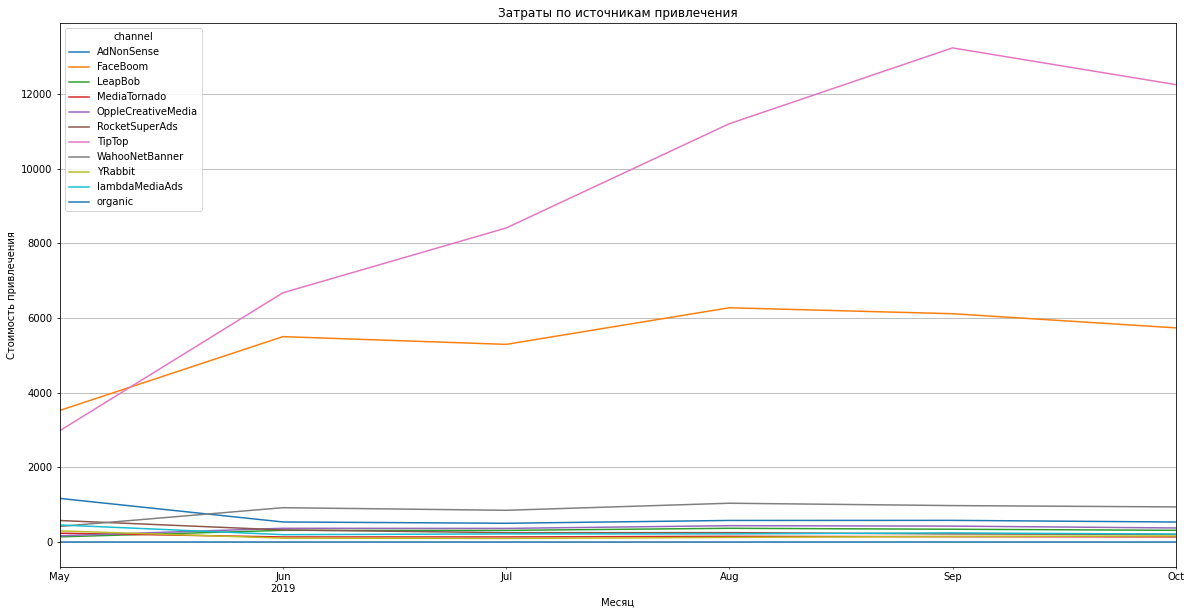

In [35]:
profiles.pivot_table(
    index='month',  # даты первых посещений
    columns='channel',  # источники переходов
    values='acquisition_cost',  # ID пользователей
    aggfunc='sum'  # подсчёт уникальных значений
).plot(figsize=(20, 10), grid=True)
plt.title('Затраты по источникам привлечения')
plt.xlabel('Месяц')
plt.ylabel('Стоимость привлечения')
plt.show()

По этому графику можем сделать следующие выводы:
* Больше всего денег потратили на привлечение пользователей из канала `TipTop` и `FaceBoom`
* По остальным каналам затраты на привлечение пользователей примерно держатся на одном уровне
* Пользователи из канала `organic` - соответственно для приложения были бесплатными

Расчитает CAC на одного пользователя и посмотрим на динамику изменения САС по каналам привлечения.

In [36]:
#Расчитаем средний САС на одного пользователя по каналам привлечения.
profiles.pivot_table(
    columns='channel', 
    values='acquisition_cost', 
    aggfunc='mean'
).round(2)

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds,organic
acquisition_cost,1.01,1.11,0.21,0.22,0.25,0.41,2.8,0.6,0.22,0.72,0.0


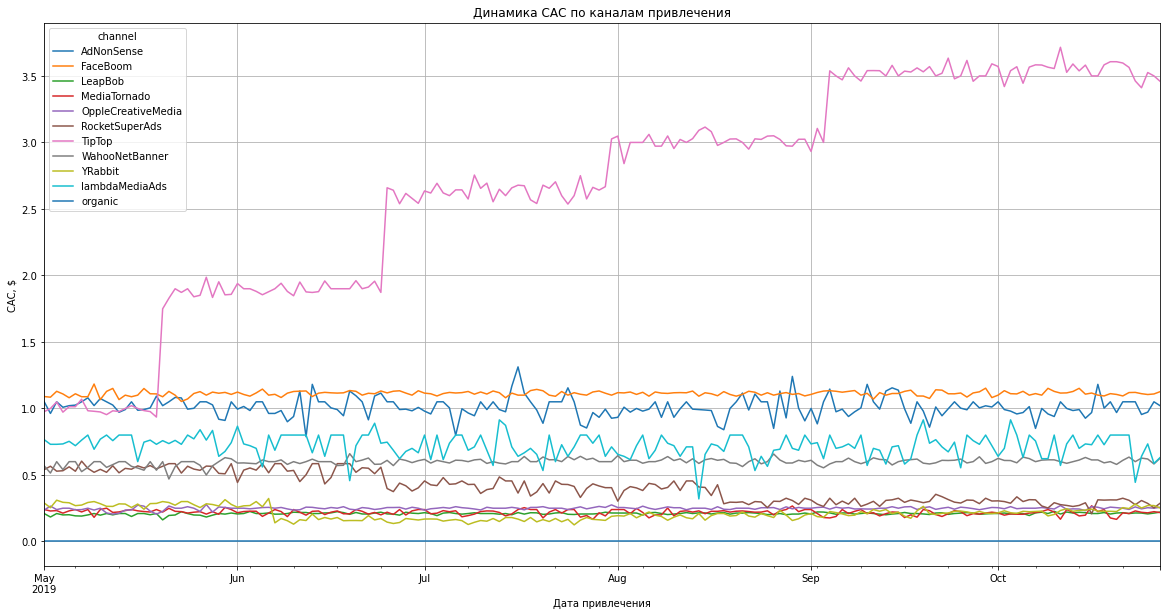

In [37]:
#Построим график динамики САС по каналам привлечения
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(20, 10))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Расчитаем средний САС на одного пользователя по всему проекту

Пользователи с канала привлечения `organic` - занижают нам среднюю стоимость привлечения. Избавимся от таких пользователей для дальнейшего анализа.

In [38]:
profiles_m = profiles.query('not (channel == "organic")')
profiles_m['channel'].unique()

array(['FaceBoom', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Посчитаем средний САС без канала Organic:

In [39]:
display(profiles_m.pivot_table(
    columns='month', 
    values='acquisition_cost', 
    aggfunc='mean'
).round(2))


print(f'Средний САС на одного пользователя для всего датафрейма: ', profiles_m['acquisition_cost'].mean().round(2))

month,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
acquisition_cost,0.8,0.99,1.1,1.18,1.3,1.3


Средний САС на одного пользователя для всего датафрейма:  1.13


С этими данными будем работать в дальнейшем.

### Выводы к третьему этапу

* Стоимость привлечения «органических» пользователей во всех когортах равна нулю, потому что они перешли в приложение самостоятельно, а не благодаря рекламе. Поэтому мы создаем новые профили без этого канала привлечения, чтобы разобраться с остальными каналами привлечения.
* Привлечение одного пользователя из рекламной сети «TipTop» обходилось компании с каждым месяцяцем все дороже и дороже. Стоимость привлечения одного пользователя в октябре - в 4 раза выше среднего САС по всем каналам привлечения. и в 3 раза выше среднего САС по маркетинговым канала привлечения.
* Судя по графику - увеличения стоимости привлечения клиента идет только за счет канала `TipTop`


## Оценка окупаемости рекламы

### Общий анализ окупаемости рекламы

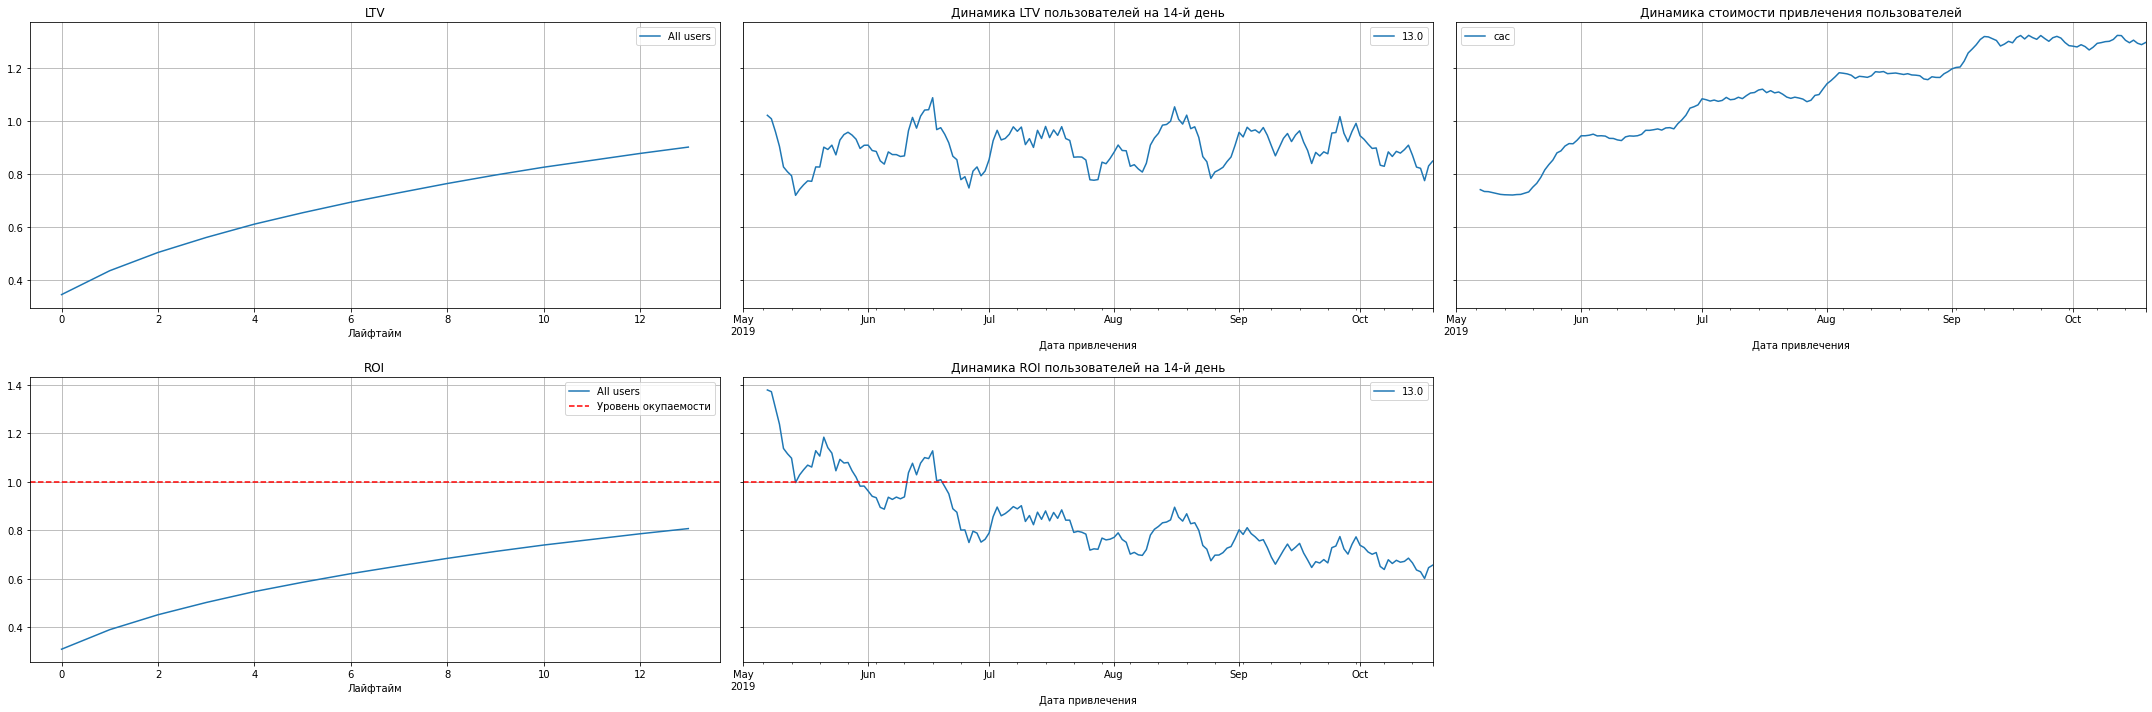

In [40]:
events = None # других событий нет
# разбиваем траты на рекламу по дням
min_date = profiles_m['dt'].min()
max_date = profiles_m['dt'].max()
days_num = (max_date - min_date).days
daily_costs = []
for index, values in ad_costs.iterrows():
    channel_name = values['channel']
    channel_costs = values['costs']
    avg_channel_costs = channel_costs / days_num
    for i in range(days_num):
        current_day = min_date + timedelta(days=i)
        daily_costs += [[current_day, channel_name, avg_channel_costs]]
daily_costs = pd.DataFrame(daily_costs, columns=['dt', 'channel', 'costs'])
daily_costs['dt'] = daily_costs['dt'].dt.date

# считаем LTV и ROI
ltv_raw_t, ltv_t, ltv_history_t, roi_t, roi_history_t = get_ltv(
    profiles_m, orders, datetime(2019, 11, 1).date(), 14, dimensions=[]
)
plot_ltv_roi(ltv_t, ltv_history_t, roi_t, roi_history_t, 14)

Проанализируем показатели:
* LTV - критичных замечаний нет
* Динамика LTV тоже достаточно неплохая
* Стоимость привлечения сильно растет, скорее всего это связано с использованием дорогих каналов привлечения пользователей.
* Пользователи окупаются приблизительно только на 15 день.
* Динамика ROI, как и стоимость привлечения начала сильно меняться в худшую сторону, начиная с Июня. 
* Динамика ROI начала ухудшаться параллельно с ростом стоимости привлечения на канале `TipTop`. 

### Маркетинговый анализ по каналам привечения.

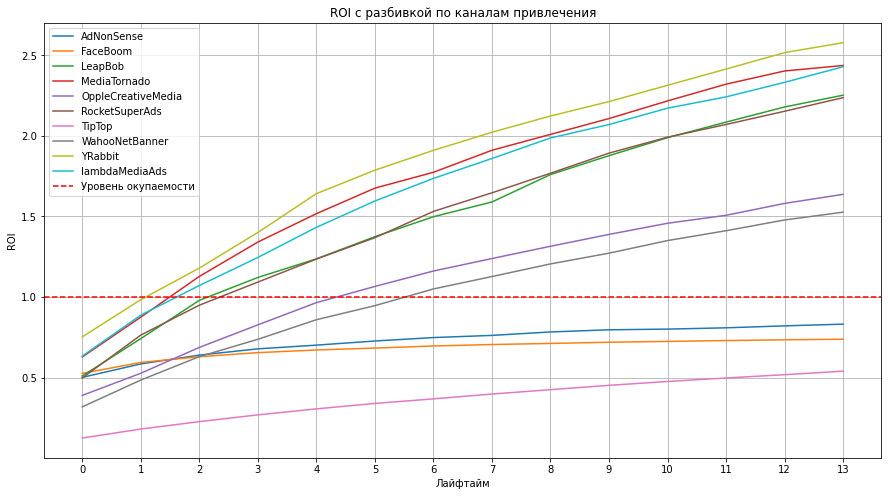

In [41]:
ltv_raw_c, ltv_c, ltv_history_c, roi_c, roi_history_c = get_ltv(profiles_m, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])

report_roi =  roi_c.drop(columns=['cohort_size', 'cac'])

# строим кривые ROI
report_roi.T.plot(grid=True, figsize=(15, 8), xticks=list(report_roi.columns.values))
plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

Исходя из графика ROI с разбивкой по каналам привлечения - есть несколько каналов, которые за 14 дней не окупаются:
* TipTop
* FaceBoom
* AdNonSense

Быстрее всего окупаются пользователи с каналов:
* YRabbit
* MedaiTornado
* lambdaMediaAds

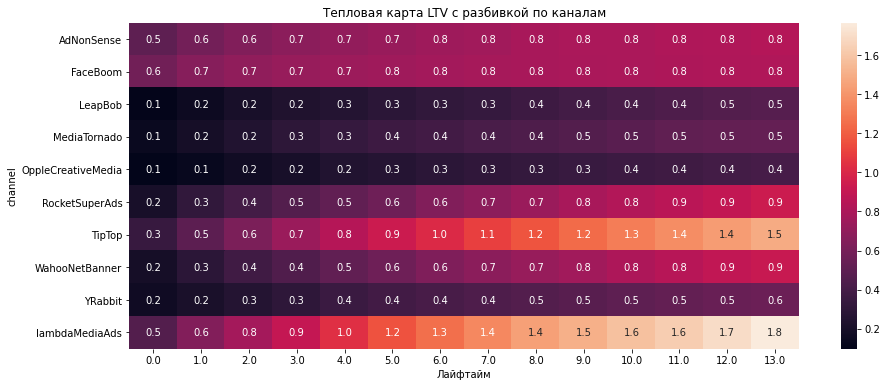

In [42]:
result_raw_c, result_grouped_c,result_in_time_c, roi_grouped_c, roi_in_time_c = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14,dimensions=['channel']
)
plt.figure(figsize=(15, 6))
sns.heatmap(ltv_c.drop(columns=['cohort_size']), annot=True, fmt='.1f')
plt.title('Тепловая карта LTV с разбивкой по каналам')
plt.xlabel('Лайфтайм')
plt.show()

Самый лучший результат у `lambdaMediaAds` и `TipTop`

In [43]:
retention_raw_c, retention_c, retention_history_c = get_retention(
    profiles_m, sessions, datetime(2019, 11, 1).date(), 14, dimensions=['channel'], ignore_horizon=True)

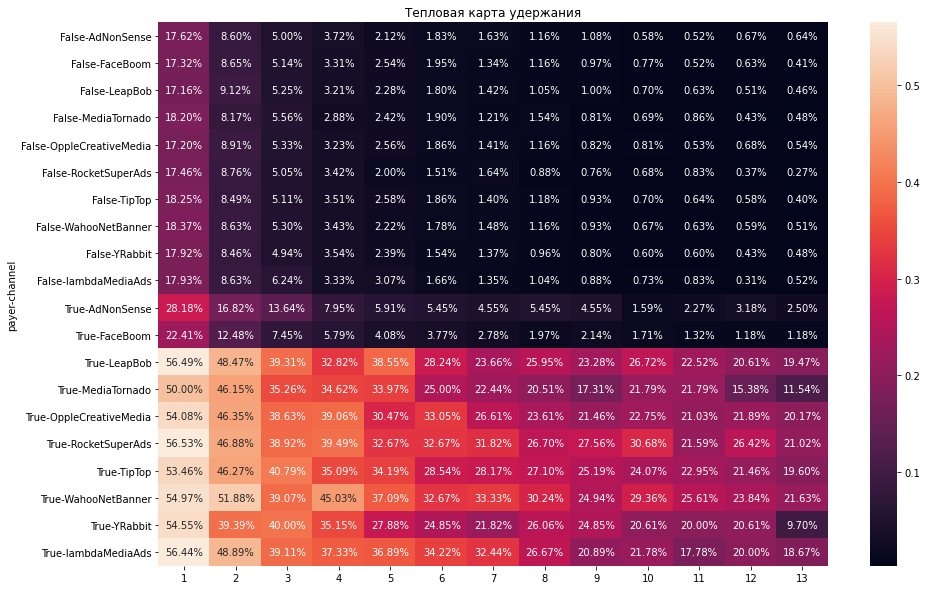

In [44]:
# строим тепловую карту удержаний
plt.figure(figsize=(15, 10))
sns.heatmap(retention_c.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

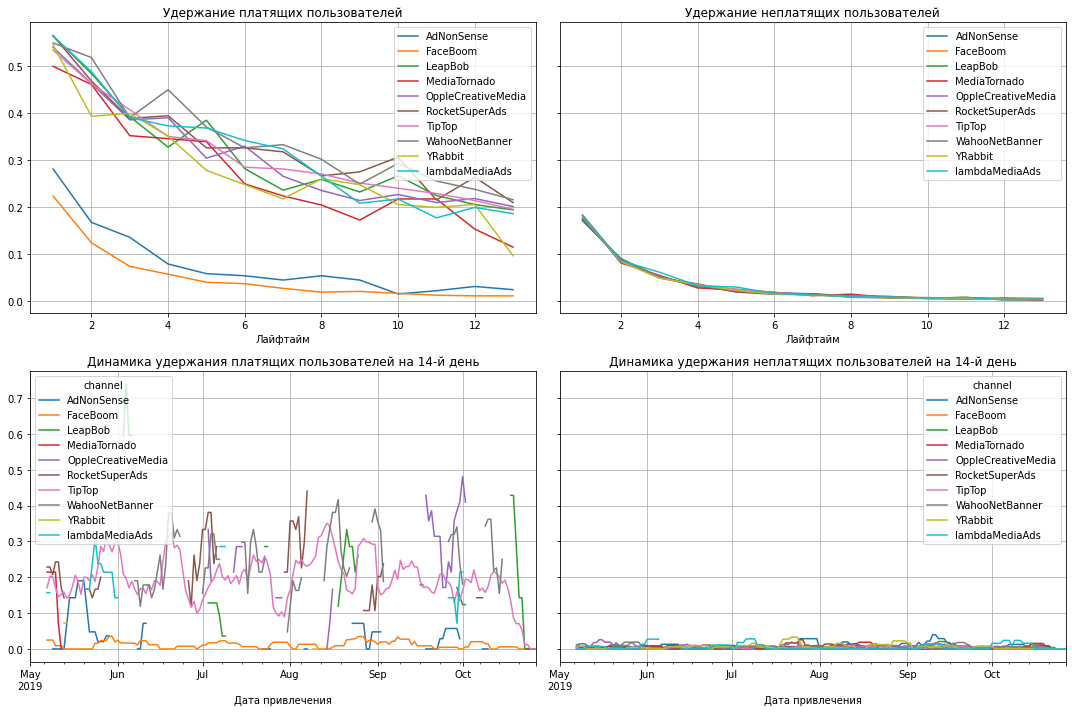

In [45]:
plot_retention(retention_c, retention_history_c, 14, window=7)

* Лучший показатель удержания среди неплатящих у `AdNonSense`.
* Лучший показатель у платящих - `WahooNetBanner` и `RocketSuperAds`.
* Самый худший показатель удержания платящих пользователей у каналов `AdNonSense` & `Faceboom`
* Худшая динамика удержания - `Faceboom`, `MediaTornado`.


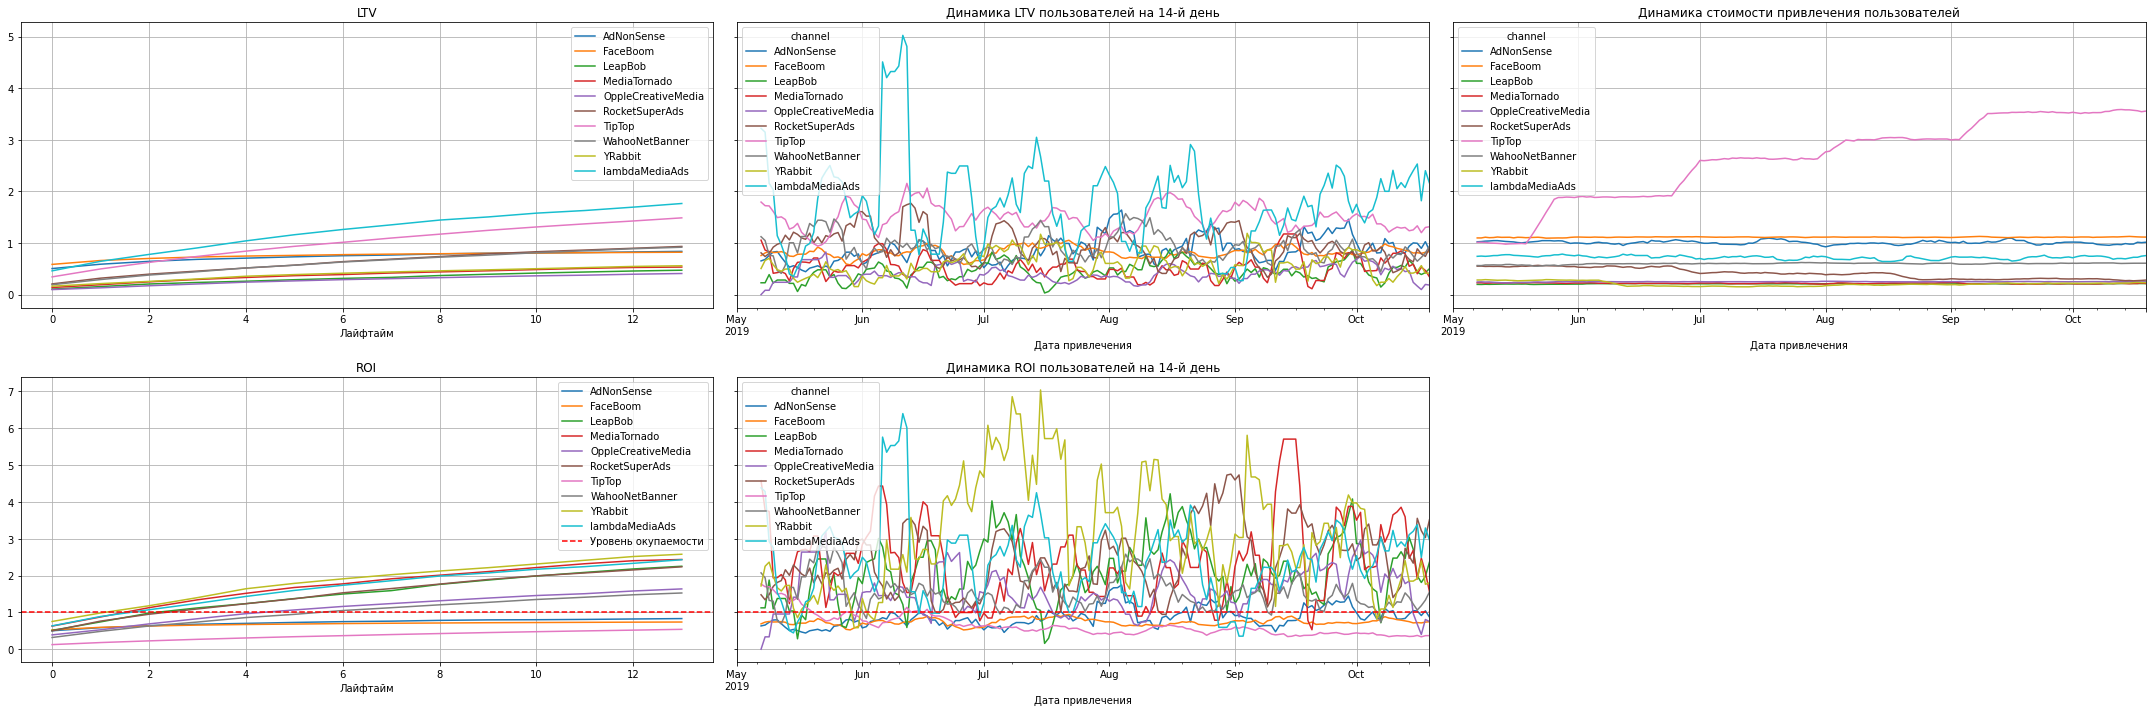

In [46]:
plot_ltv_roi(ltv_c, ltv_history_c, roi_c, roi_history_c, 14)

* Как мы и видел на тепловых картах и предыдущих графиках LTV - лучше у пользователей, пришедших с каналов `lambdaMediaAds` и `TipTop`
* На 14 день лучший LTV на протяжении всего изучаемого периода был у канала `lambdaMediaAds`
* Как и в предыдущих графика - стоимость привлечения растет только у канала `TipTop`
* Несколько каналов привлечения не подходят нам по условию бизнес-плана(окупаемость за 14 дней) - это пользователи с каналов привлечения: `TipTop` , `FaceBoom`, `AdNonSense`.
* Судя по динамике ROI - пользователи с этих трёх каналов так и не выходили на окупаемость за 14 дней за весь изучаемый период: `TipTop` , `FaceBoom`, `AdNonSense`

Проверим конверсию по каналам привлечения.

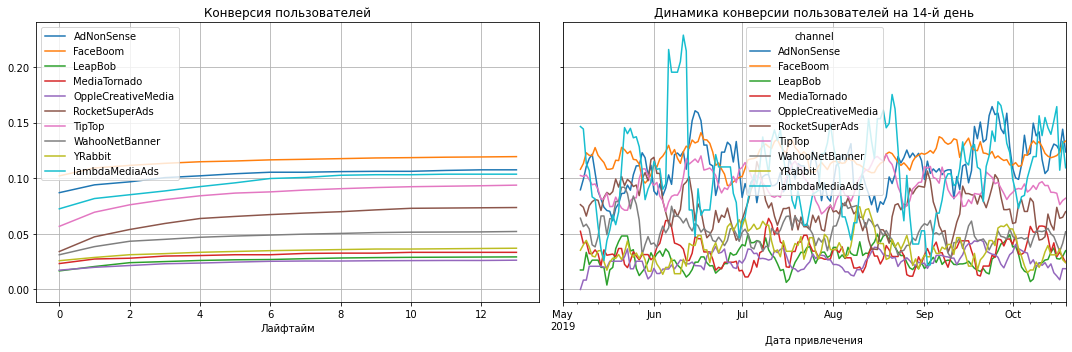

In [47]:
conversion_raw_c, conversion_c, conversion_history_c = get_conversion(
    profiles_m,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_conversion(conversion_c, conversion_history_c, 14, window=7)

* Самая лучшая конверсия за лайфтайм у `FaceBoom`, но судя по динамике конверсии на 14-ый день за весь период - выигрывает `lambdaMediaAds` и `AdNonSense`. 

* Самая худшая конверсия у `WahooNetBanner`, `LeapBob`, `MediaTornado`.


### Маркетинговый анализ по странам пользователей.

Проделаем все те же шаги, что и в предыдущей части, для начала используем все функции.

In [48]:
ltv_raw_d, ltv_d, ltv_history_d, roi_d, roi_history_d = get_ltv(
    profiles_m, 
    orders, 
    datetime(2019, 11, 1).date(), 
    14, 
    dimensions=['region']
)

result_raw_d, result_grouped_d,result_in_time_d, roi_grouped_d, roi_in_time_d = get_ltv(
    profiles_m,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['region']
)

retention_raw_d, retention_d, retention_history_d = get_retention(
    profiles_m,
    sessions,
    datetime(2019, 11, 1).date(),
    14,
    dimensions = ['region'],
    ignore_horizon=True
)

conversion_raw_d, conversion_d, conversion_history_d = get_conversion(
    profiles_m,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['region'],
    ignore_horizon=False,
)

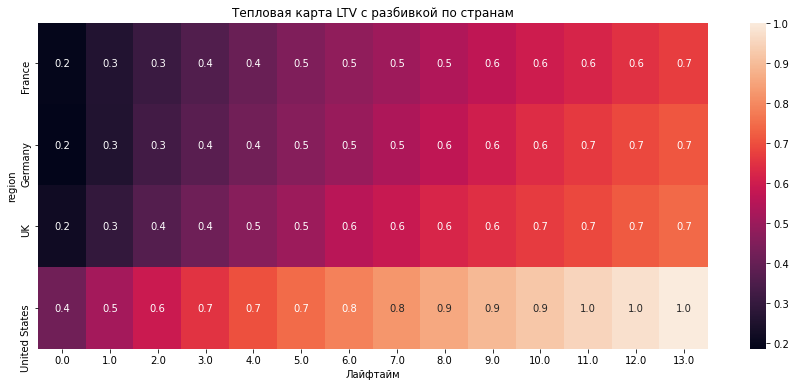

In [49]:
# Построим Heatmap с разбивкой по странам
plt.figure(figsize=(15, 6))
sns.heatmap(ltv_d.drop(columns=['cohort_size']), annot=True, fmt='.1f')
plt.title('Тепловая карта LTV с разбивкой по странам')
plt.xlabel('Лайфтайм')
plt.show()

По тепловой карте лучший показатель LTV по региону - США. Остальные регионы идут наравне.

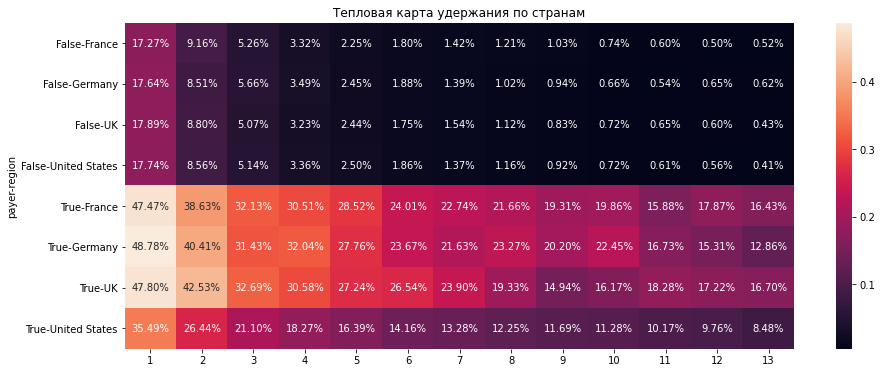

In [50]:
# строим тепловую карту
plt.figure(figsize=(15, 6))
sns.heatmap(retention_d.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания по странам')
plt.show()

* По удержанию платящих пользователей в лидеры попали - UK и France. В то время как США занимает последнее место.
* По неплатящим пользователям - лучший показатель у Германии, но конкуренты недалеко ушли.

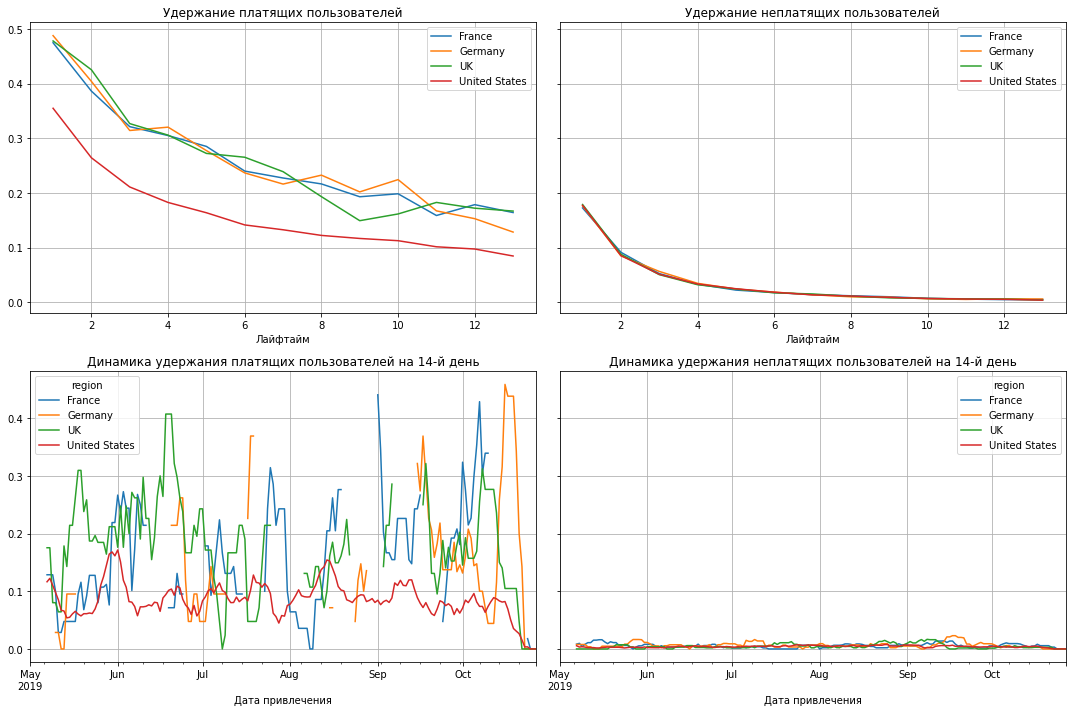

In [51]:
#Строим кривые удержания с разбивкой по платящим/неплатящим
plot_retention(retention_d, retention_history_d, 14, window=7)

По кривым удержания можем сделать следущие выводы:
* Удержания платящих пользователей лучше в Европе.
* Удержания неплатящих пользователей примерно на одном уровне.
* Динамика удержания платящих пользователей за весь период на 14-ый день - лучше в Европе. В октябре удержание пользователей в США существенно ухудшился.
* По неплатящим ситуация по всем регионам примерно оданиковая. Только иногда выбивается вперд Германия.

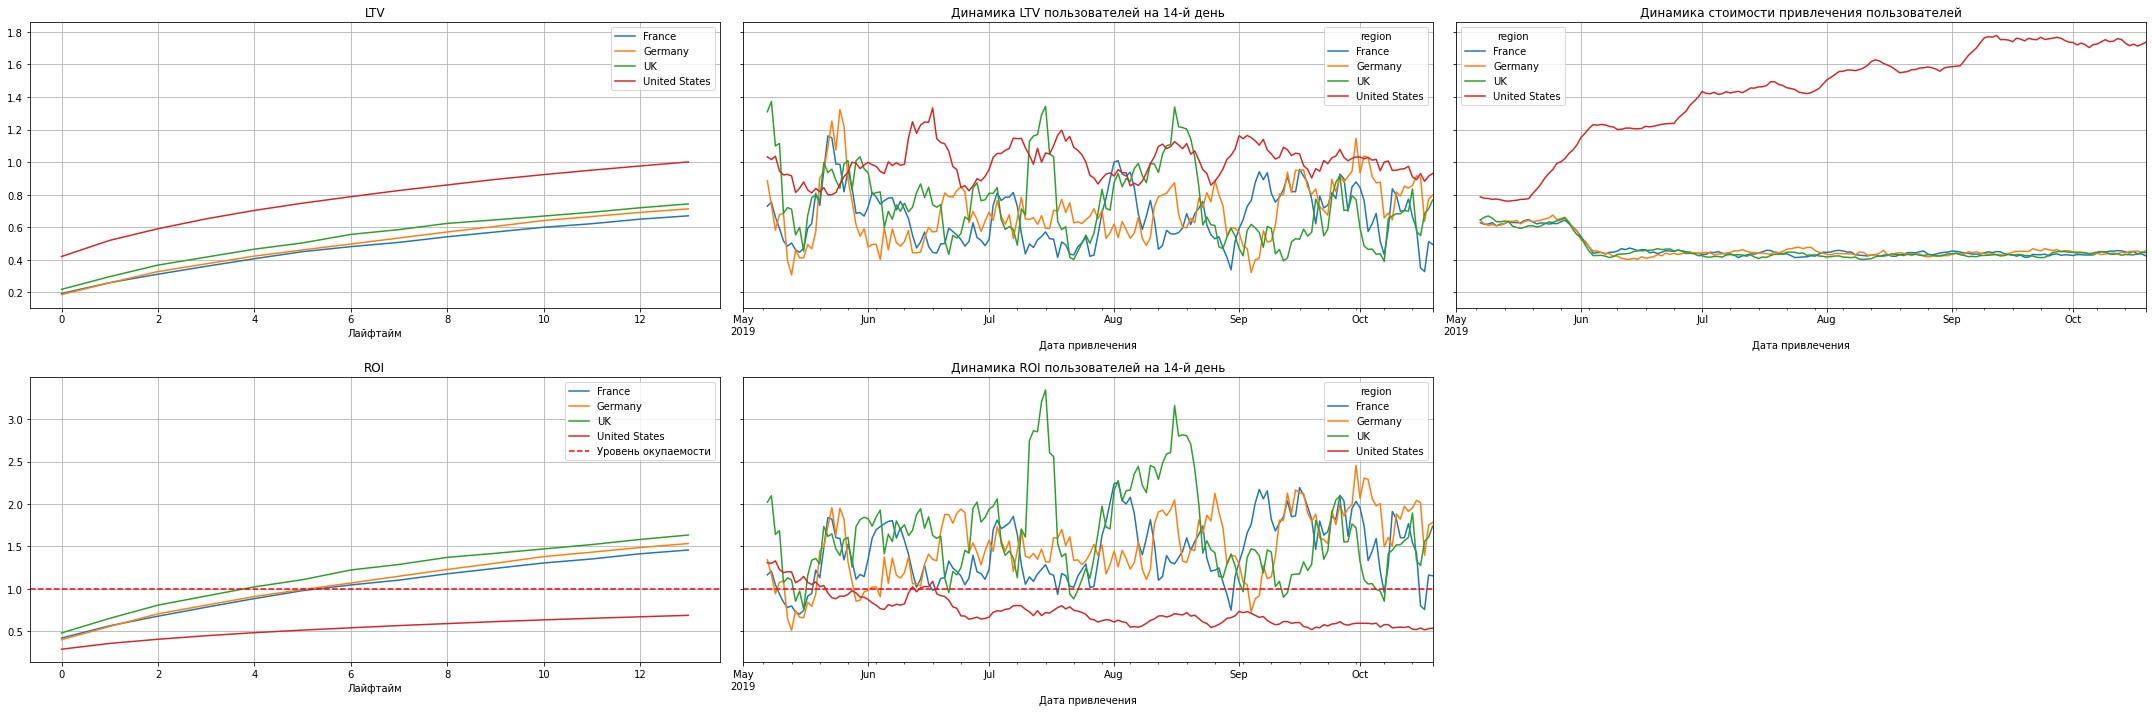

In [52]:
#Строим кривые ROI и LTV
plot_ltv_roi(ltv_d, ltv_history_d, roi_d, roi_history_d, 14)

По кривым ROI по регионам строим следующие выводы:
* LTV зай выбранный нами лайфтайм лучше в США;
* Динамика LTV на 14-ый день - самый стабильный и высокий в США, в то время как LTV европейских пользователей в сентябре начал снижаться.
* Самые "дорогие" пользователи находятся в США и судя по динамике стоимости привлечения - основной канал тут это `TipTop`.
* Из-за стоимости привлечения - пользователи из США не окупаются на 14-ый день. При этом пользователи из Европы окупаются уже на 4-5 день.
* Судя по динамике ROI - пользователи из США практически никогда не окупались на 14-ый день, а вот пользователи из Европы практически всегда окупались на 14-ый день.

Проверим конверсию пользователей по странам

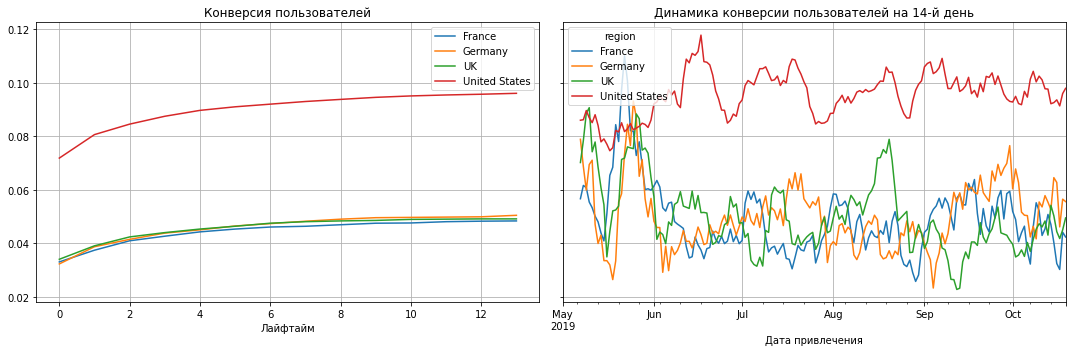

In [53]:
#Строим кривые конверсии
plot_conversion(conversion_d, conversion_history_d, 14, window=7)

    В начале исследования мы писали о том, что пользователи из США чаще совершают покупки, но стоимость привлечения одного пользователя у них слишком высокая и есть растущий тренд по увеличению этой стоимости. Хотя и при более дальнем горизонте - у пользователей из США LTV больше - такие пользователи нам не подходят из-за того, что окупаться они начинают дольше, чем через 14 дней, несмотря на их конверсию.
    
    В то время как Пользователи из United Kingdom - подходят нам по всем показателям. Они практически всегда имеют ROI > 1 раньше чем через 14 дней. Стоимость рекламы в этом регионе - намного дешевле, рекламы в США.

### Маркетинговый анализ по девайсам

Используем все необходимые функции, чтобы получить данные по `device`:

In [54]:
ltv_raw_dev, ltv_dev, ltv_history_dev, roi_dev, roi_history_dev = get_ltv(
    profiles_m, 
    orders, 
    datetime(2019, 11, 1).date(), 
    14, 
    dimensions=['device']
)

result_raw_dev, result_grouped_dev,result_in_time_dev, roi_grouped_dev, roi_in_time_dev = get_ltv(
    profiles_m,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['device']
)

retention_raw_dev, retention_dev, retention_history_dev = get_retention(
    profiles_m,
    sessions,
    datetime(2019, 11, 1).date(),
    14,
    dimensions = ['device'],
    ignore_horizon=True
)

conversion_raw_dev, conversion_dev, conversion_history_dev = get_conversion(
    profiles_m,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['device'],
    ignore_horizon=False,
)

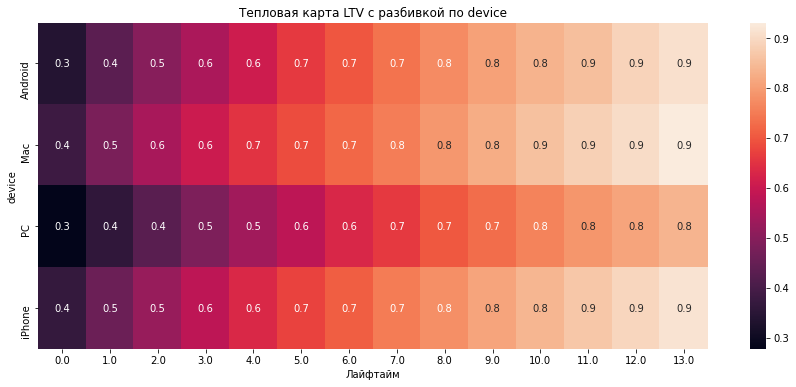

In [55]:
plt.figure(figsize=(15, 6))
sns.heatmap(ltv_dev.drop(columns=['cohort_size']), annot=True, fmt='.1f')
plt.title('Тепловая карта LTV с разбивкой по device')
plt.xlabel('Лайфтайм')
plt.show()

Судя по тепловой карте - LTV примерно одинаковые.


Построем тепловую карту по удержанию платящих/неплатящих пользователей:

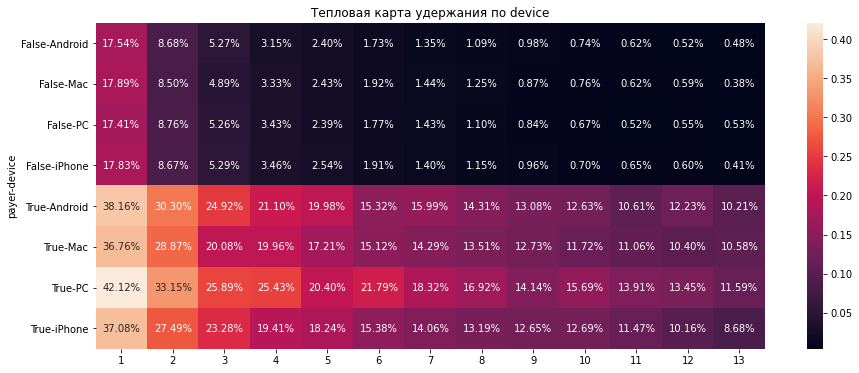

In [56]:
# строим тепловую карту
plt.figure(figsize=(15, 6))
sns.heatmap(retention_dev.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания по device')
plt.show()

Судя по тепловой карте - лучший показатель по удержанию платящих пользователей среди пользователей компьютеров. Видимо прокрастинировать удобнее на большом экране.

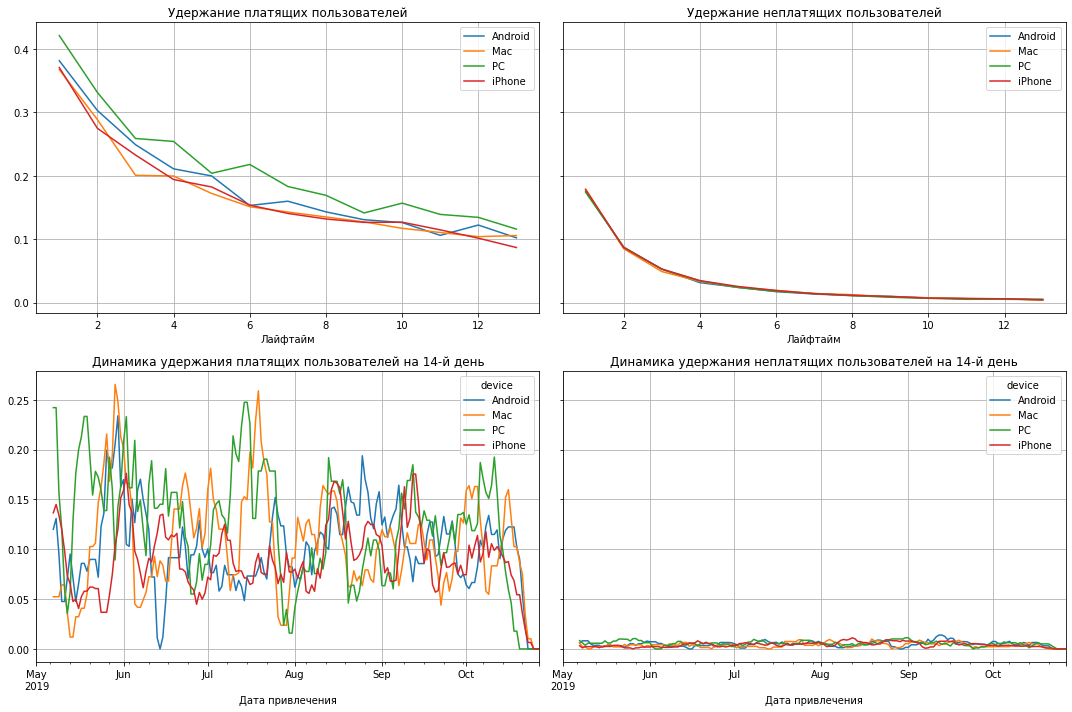

In [57]:
#Строим кривые удержания с разбивкой по платящим/неплатящим
plot_retention(retention_dev, retention_history_dev, 14, window=7)

Выводы по кривым удержания платящих/неплатящих:
* По платящим пользователям, как мы и убедились на хитмэпе - у ПК.
* Удержания по неплатящим, как и по предудущим наблюдениям - идентичны.
* Динамика удержания на 14-ый день среди платящих - самый худший показатель у пользователей IPhone и Android. Лидируют "большие экраны"

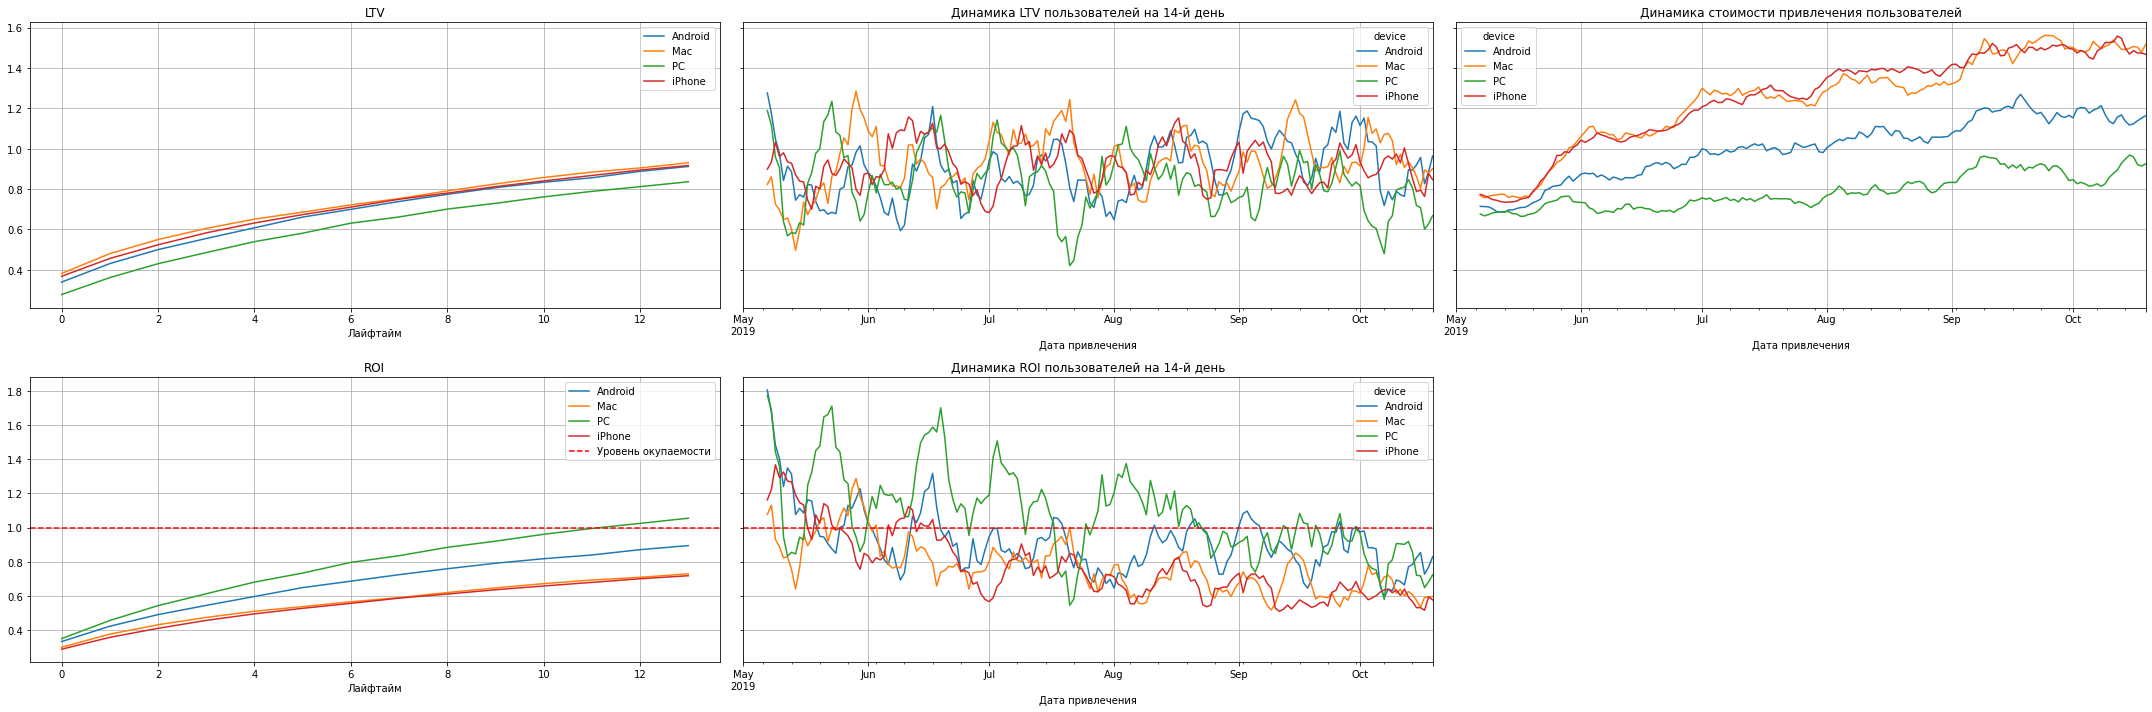

In [58]:
#Строим кривые ROI и LTV
plot_ltv_roi(ltv_dev, ltv_history_dev, roi_dev, roi_history_dev, 14)

Выводы по ROI|LTV:
* LTV за лайфтайм и период практически одинаковый, немного отстают пользователи ПК.
* Динамика стоимости привлечения по всем девайсам растет, но сильнее всего выросла для `Mac` и `Iphone`
* Только пользователи ПК окупаются за выбранный нами лайфтайм
* За весь период видим заметную тенденцию по снижению ROI за весь период.

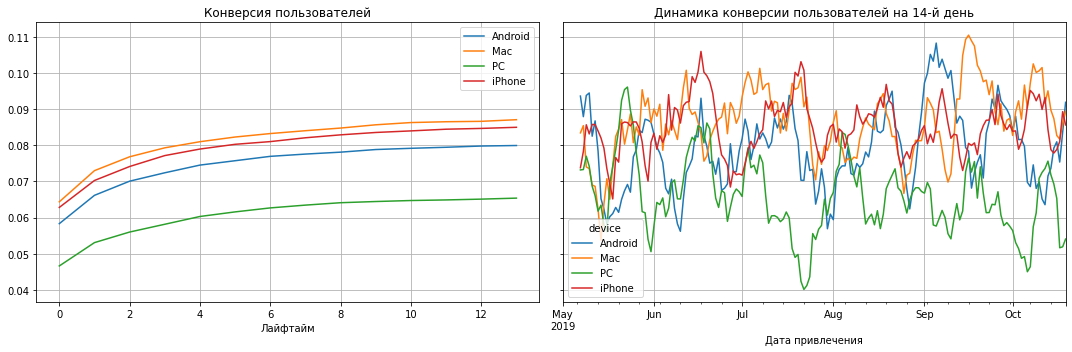

In [59]:
#Строим кривые конверсии
plot_conversion(conversion_dev, conversion_history_dev, 14, window=7)

Выводы по кривым конверсии в разбивке по девайсам.
* За лайфтайм лучше конверсия среди пользователей `Mac`&`IPhone`.
* по динамике конверсии - можно заметить, что пользователи ПК упали на "дно"

### Выводы к четвертому этапу.

Мы построили графики, чтобы посмотреть, данные под разными углами и вот какие выводы были сделаны:
* Реклама на канале `TipTop` - слишком дорогая. Она влияет на общую динамику ROI и CAC - по всем проверенным графикам - снижается уровень окупаемости, сразу после увеличения стоимости рекламы на этом канале.
* Лучше всего платят и конвертируются пользователи из Европы. Так же стоимость привлечения таких пользователей достаточно низкая, по сравнению со стоимостью привлечения пользователей из США.
* Анализ по девайсам практически не дал нам никакой информации. Каких-то сильных отклонений там нет.
* Реклама на канале `lambdaMediaAds` - по многим показателям подходит нашему бизнес-плану.
* Стоимость привлечения пользователей из США - самая высокая среди всех регионов.

## Выводы по исследованию.

### Ответы на вопросы по результатам исследования.

   Проведя анализ всех данных во время исследования, мы ответили на несколько интересующих нас вопросов по бизнес-плану.
1. Окупается ли реклама в целом?
На текущий момент - реклама не окупается на 14-ый день. Необходимо предпринять некоторые действия для перераспределения затрат по каналам привлечения пользователей.
2. Какие устройства, страны и каналы могут снижать окупаемость рекламы?
* Пользователи с устройствами `Mac`, `IPhone` - не окупаются на 14-ый день.
* Хуже всего окупаются пользователи из `USA` - причина в высокой стоимости привлечения 1-го пользователя.
* Каналы снижающие окупаемость рекламы и увеличивающие CAC - несомненно это `TipTop` и `FaceBoom`. Остальные каналы привлечения подходят к требованиям нашего бизнес-плана.
* `TipTop`, `FaceBoom`, `AdNonSense` - проблемы с удержанием пользователей.
* Пользователи `PC` проблемы с конверсией.
* Пользователи из Европы окупаются в среднем на 7 день.

### Рекомендации для отдела маркетинга.

На основе полученных данных, есть несколько рекомендаций:
* Пересмотреть каналы привлечения пользователей. Снизить долю затрат на канал привлечения `TipTop` - у этого канала одна из самых маленьких доль платящих пользователей, плюс ко всему - это самый дорогой канал привлечения, цена на привлечение одного пользователя за последние несколько месяцев увеличилась в 3,5 раза.
* Перераспределить ресурсы по привлечению пользователей на основе стран. Так как, согласно бизнес-плану - окупаемость должна наступить не позднее 14 дня - стоит присмотреться к Европейскому сегменту рынка. Несмотря на небольшое кол-во пользователей - показатели ROI у них самые лучшие, именно такие пользователи окупаются быстрее, чем 14 дней и помогают удерживать ROI по системе на уровне 14 дней.
* Согласно данным по девайсам - пользователи `Mac`, `IPhone` не успевают окупиться за 14 дней. Возможно в приложении на платформе IOS и MacOS - установлен пробный период пользования приложением 14 дней, потому что в долгосрочной перспективе - эти пользователи могут принести больше прибыли. Но по какой-то причине пользователи этих девайсов - начинают позже окупаться.
* Обратить внимание на канал привлечения - `lambdaMediaAds`, по всем показателям этот канал привлечения - самый выгодный и пользователи пришедшие по этому каналу окупаются быстрее предыдущих и несмотря на это - стоимость привлечения одного пользователя - одна из самых низких.
* Так же стоит обратить внимание на `WoohooNetBanner` и `RocketSuperAds` - у них самый лучший показатель удержания платящих пользователей.
* Самая лучшая конверсия и удержание среди пользователей `Mac` & `IPhone` - необходимо найти способ уменьшения затрат на привлечение пользователей по этим устройствам, возможно изменение канала привлечения поможет решить эту проблему.
